<a href="https://colab.research.google.com/github/vedantd2809/DC_GAN/blob/main/poke_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/kaggle/pokemon/

/content/drive/MyDrive/kaggle/pokemon


In [91]:
# !unzip /content/drive/MyDrive/kaggle/pokemon/archive.zip -d pokemon

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape, Flatten, Dense , LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Reshape, Dense, LeakyReLU, Dropout, BatchNormalization,Concatenate,ReLU,LeakyReLU,Activation,Input,MaxPool2D,MaxPooling2D
from keras.layers import Add
from tensorflow.keras.optimizers import Adam, SGD
import cv2
from cv2 import resize
import matplotlib.pyplot as plt

In [ ]:
HEIGHT = 128
WIDTH = 128
CHANNEL = 3
HW = HEIGHT*WIDTH
img_sh = HEIGHT,WIDTH,CHANNEL
d = HEIGHT*WIDTH*CHANNEL
img_sh

(128, 128, 3)

In [ ]:
# def lrelu(x,n,leak = 0.2):
#     return tf.maximum(x,leak = x,name = n)

In [ ]:
path = '/content/drive/MyDrive/kaggle/pokemon/pokemon/images/images/'
a = sorted(os.listdir(path))


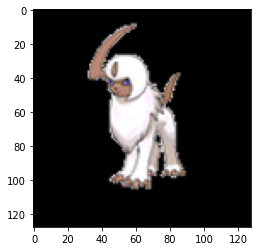

In [ ]:
a = sorted(os.listdir(path))
img = []
for i in a:
    b = cv2.imread(path+i)
    b = cv2.resize(b,(HEIGHT,WIDTH))
    b = b.reshape(128,128,3)
    img.append(b)

plt.imshow(img[2])
img = np.array(img)
img = img / 255.0
# img = img.reshape(-1)

In [ ]:
img.shape

(809, 128, 128, 3)

In [ ]:
def discriminator_model(img_sh):
    
    i = Input(shape=(img_sh))
    
    x = Flatten()(i)

    x = Dense(1024,activation=LeakyReLU())(x)
    
    x = Dense(512,activation=LeakyReLU())(x)
    
    x = Dense(256,activation=LeakyReLU())(x)
    
    x = Dense(1,activation='sigmoid')(x)
    
    model = Model(i,x)
    return model

In [ ]:
latent_dim = 100

def generator_model(latent_dim):
    
    i = Input(shape=(latent_dim,))
    x = Dense(16*16*64, use_bias=False, input_shape=(100,))(i)
#     x = Reshape(128,128,3)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Reshape((8,8,256))(x)

    x = Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False,)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    
    x = Conv2DTranspose(3, (5, 5), strides=(2), padding='same', use_bias=False, activation='tanh')(x)
    
    
    model = Model(i,x)

    return model


generator_model(latent_dim).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_14 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 128)       512 

In [ ]:
discriminator = discriminator_model(img_sh)
discriminator.compile( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = generator_model(100)
discriminator.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              50332672  
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 50,989,057
Trainable params: 50,989,057
Non-trainable params: 0
_______________________________________________

In [ ]:
z = Input(shape=(latent_dim,))
z.shape

TensorShape([None, 100])

In [ ]:
gen = generator(z)
gen

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'model_6')>

In [ ]:
discriminator.trainable = False
fake_pred = discriminator(gen)

In [ ]:
combined_model = Model(z, fake_pred)

combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [77]:
batch_size = 128
epochs = 1000
sample_period = 500

In [ ]:
zeros = np.zeros(batch_size)
ones = np.ones(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_img'):
    os.makedirs('gan_img')

In [78]:
def sample_images(a):
    rows, cols = 2,2
    noise = np.random.normal(0,1,(rows * cols, latent_dim))
    imgs = generator.predict(noise)


    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows,cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx,:,:,0].reshape(HEIGHT,WIDTH), cmap = 'gray')
            axs[i,j].axis('off')
            idx += 1 
    fig.savefig("gan_img/f%d.png"% a)
    plt.close()

In [86]:
for epoch in range(epochs):
      
    idx = np.random.randint(0, img.shape[0], batch_size)
    real_imgs = img[idx]
    
    
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    
#     plt.imshow(fake_imgs)
    
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
        d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
    if epoch % 100 == 0:
        sample_images(epoch)

epoch: 1/1000, d_loss: 0.18,         d_acc: 0.95, g_loss: 2.45
epoch: 101/1000, d_loss: 0.16,         d_acc: 0.95, g_loss: 2.45
epoch: 201/1000, d_loss: 0.21,         d_acc: 0.95, g_loss: 2.67
epoch: 301/1000, d_loss: 0.18,         d_acc: 0.95, g_loss: 2.57
epoch: 401/1000, d_loss: 0.28,         d_acc: 0.93, g_loss: 2.56
epoch: 501/1000, d_loss: 0.05,         d_acc: 0.98, g_loss: 0.03
epoch: 601/1000, d_loss: 0.62,         d_acc: 0.59, g_loss: 11.42
epoch: 701/1000, d_loss: 0.36,         d_acc: 0.92, g_loss: 3.11
epoch: 801/1000, d_loss: 0.31,         d_acc: 0.94, g_loss: 2.83
epoch: 901/1000, d_loss: 0.23,         d_acc: 0.95, g_loss: 2.69


In [90]:
noise2 = np.random.rand(1,latent_dim)
l = generator.predict(noise2)
# plt.imshow(l[0])